--- 📸 نظام المعالجة الاحترافي مع معاينة الخلفيات ---
1) خلفية بيضاء (أحوال/جواز)
2) خلفية مخصصة (LinkedIn/Professional)
اختر الوضع (1 أو 2): 1


Saving pic for test7.jpg to pic for test7.jpg
⏳ جاري معالجة الصورة الأصلية...

✨ النتيجة النهائية المعتمدة:


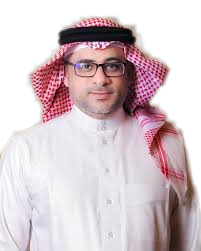

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
import os, glob
import cv2
import numpy as np
from PIL import Image
from rembg import remove
from google.colab import files
from google.colab.patches import cv2_imshow

# --- 1) وظائف المعالجة الاحترافية (لا تغيير هنا لضمان الجودة) ---

def professional_composite(fg_rgba, bg_bgr):
    alpha = fg_rgba[:, :, 3]
    # تنظيف الحدود (Erosion)
    kernel = np.ones((3,3), np.uint8)
    alpha = cv2.erode(alpha, kernel, iterations=1)
    # تنعيم الحواف
    alpha = cv2.GaussianBlur(alpha, (5, 5), 0)
    alpha_mask = alpha.astype(float) / 255.0
    alpha_mask = cv2.merge([alpha_mask, alpha_mask, alpha_mask])

    fg_bgr = fg_rgba[:, :, :3].astype(float)
    th, tw = fg_rgba.shape[:2]

    # ضبط مقاس الخلفية
    bh, bw = bg_bgr.shape[:2]
    scale = max(tw/bw, th/bh)
    bg_res = cv2.resize(bg_bgr, (int(bw*scale), int(bh*scale)), interpolation=cv2.INTER_LANCZOS4)
    bg_fitted = bg_res[(bg_res.shape[0]-th)//2 : (bg_res.shape[0]-th)//2 + th,
                       (bg_res.shape[1]-tw)//2 : (bg_res.shape[1]-tw)//2 + tw].astype(float)

    blended = (fg_bgr * alpha_mask) + (bg_fitted * (1 - alpha_mask))
    return np.clip(blended, 0, 255).astype(np.uint8)

# --- 2) بداية البرنامج ---

print("--- 📸 نظام المعالجة الاحترافي مع معاينة الخلفيات ---")
print("1) خلفية بيضاء (أحوال/جواز)")
print("2) خلفية مخصصة (LinkedIn/Professional)")

mode = input("اختر الوضع (1 أو 2): ")

uploaded = files.upload()
if uploaded:
    path = list(uploaded.keys())[0]
    img = Image.open(path).convert("RGB")

    print("⏳ جاري معالجة الصورة الأصلية...")
    raw_cutout = remove(img)
    rgba = np.array(raw_cutout)
    rgba = cv2.cvtColor(rgba, cv2.COLOR_RGBA2BGRA)

    if mode == "1":
        bg = np.full((rgba.shape[0], rgba.shape[1], 3), 255, dtype=np.uint8)
    else:
        # --- ميزة المعاينة البصرية الجديدة ---
        bg_files = sorted(glob.glob("backgrounds/*.jpg") + glob.glob("backgrounds/*.png"))

        if not bg_files:
            print("⚠️ لم يتم العثور على صور في مجلد backgrounds!")
            bg = np.full((rgba.shape[0], rgba.shape[1], 3), 240, dtype=np.uint8)
        else:
            print("\n🖼️ اختر الخلفية من المعاينة التالية:")

            # إنشاء لوحة عرض للمعاينة
            preview_list = []
            for i, f in enumerate(bg_files):
                temp_bg = cv2.imread(f)
                # تصغير الصورة للمعاينة فقط
                temp_bg = cv2.resize(temp_bg, (150, 100))
                # كتابة الرقم على صورة المعاينة
                cv2.putText(temp_bg, str(i), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
                preview_list.append(temp_bg)

            # عرض الصور بجانب بعضها (كل 5 صور في صف)
            for i in range(0, len(preview_list), 5):
                row = np.hstack(preview_list[i:i+5])
                cv2_imshow(row)

            idx = int(input("\nأدخل رقم الخلفية التي أعجبتك: "))
            bg = cv2.imread(bg_files[idx])

    # تطبيق الدمج الاحترافي المعتمد
    result = professional_composite(rgba, bg)

    # تحسين حدة الملامح بشكل خفيف جداً
    sharpen_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]]) * 0.05
    result = cv2.addWeighted(result, 1.0, cv2.filter2D(result, -1, sharpen_kernel), 0.2, 0)

    print("\n✨ النتيجة النهائية المعتمدة:")
    cv2_imshow(result)

    # حفظ وتحميل
    output_name = "final_professional_result.png"
    cv2.imwrite(output_name, result)
    files.download(output_name)